In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from utils import RESULTS_DIR, SUBJECTS, COCO_IMAGES_DIR, STIM_INFO_PATH
from data import MODALITY_AGNOSTIC, TRAINING_MODES, CAPTION, IMAGE, DEFAULT_VISION_FEATURES
from eval import ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST, get_distance_matrix, dist_mat_to_pairwise_acc
from notebook_utils import create_result_graph, plot_metric_catplot, load_results_data, ACC_MEAN, METRICS_ERROR_ANALYSIS, get_data_default_feats, calc_model_feat_order, FEATS_MULTIMODAL, DEFAULT_FEAT_OPTIONS
from matplotlib import patches

sns.set_style("ticks", {'axes.grid': True})
sns.set_theme(font_scale=1.6)

from data import DEFAULT_FEATURES, DEFAULT_VISION_FEATURES, DEFAULT_LANG_FEATURES, TRAINING_MODES, MODALITY_AGNOSTIC, MODALITY_SPECIFIC_IMAGES, MODALITY_SPECIFIC_CAPTIONS


In [2]:
MODELS = [
    "random-imagebind", "vit-b-16", "vit-l-16", "vit-h-14", "resnet-18", "resnet-50", "resnet-152", "dino-base", "dino-large", "dino-giant",
    "bert-base-uncased", "bert-large-uncased", "llama2-7b", "llama2-13b", "mistral-7b", "mixtral-8x7b", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl",
    "visualbert", "bridgetower", "vilt", "siglip", "paligemma2", "clip", "flava", "blip2", "imagebind"
]

# for model in MODELS:
#     print(model, end=" ")


In [3]:
all_data = load_results_data(MODELS, recompute_acc_scores=False)

all_data = all_data[all_data["mask"] == "whole_brain"]
all_data_vol = all_data[all_data.surface == False].copy()

all_data = all_data[all_data.surface == True].copy()

multimodal_models = all_data[all_data.features.isin(FEATS_MULTIMODAL)].model.unique().tolist()
vision_models = [m for m in all_data[all_data.features == "vision"].model.unique() if len(all_data[all_data.model == m].features.unique()) == 1]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 714/714 [00:00<00:00, 1752.40it/s]


In [4]:
data_default_feats = get_data_default_feats(all_data)

In [5]:
dd = data_default_feats.copy()

dd = dd[dd.subject == 'sub-01']
dd = dd[dd.model == 'dino-base']
dd = dd[dd.metric.isin(['pairwise_acc_images', 'pairwise_acc_captions'])]
dd = dd[dd.training_mode == 'agnostic']
display(dd)


,alpha,model,subject,features,test_features,vision_features,lang_features,training_mode,mask,num_voxels,surface,resolution,metric,value,model_feat
63,1000000.0,dino-base,sub-01,vision,vision,vision_features_mean,n_a,agnostic,whole_brain,327684,True,fsaverage7,pairwise_acc_captions,0.781781,dino-base_vision
64,1000000.0,dino-base,sub-01,vision,vision,vision_features_mean,n_a,agnostic,whole_brain,327684,True,fsaverage7,pairwise_acc_images,0.901242,dino-base_vision


In [6]:
dd = data_default_feats.copy()

dd = dd[dd.subject == 'sub-01']
dd = dd[dd.model == 'gpt2-small']
dd = dd[dd.metric.isin(['pairwise_acc_images', 'pairwise_acc_captions'])]
dd = dd[dd.training_mode == 'agnostic']
display(dd)


,alpha,model,subject,features,test_features,vision_features,lang_features,training_mode,mask,num_voxels,surface,resolution,metric,value,model_feat
133,1000000.0,gpt2-small,sub-01,lang,lang,n_a,lang_features_mean,agnostic,whole_brain,327684,True,fsaverage7,pairwise_acc_captions,0.869565,gpt2-small_lang
134,1000000.0,gpt2-small,sub-01,lang,lang,n_a,lang_features_mean,agnostic,whole_brain,327684,True,fsaverage7,pairwise_acc_images,0.882195,gpt2-small_lang


## Feature comparison for multimodal models

In [7]:
data_mod_agnostic_train = all_data[(all_data.metric == ACC_MEAN) & (all_data.training_mode == MODALITY_AGNOSTIC)]


with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    # grouped = data_mod_agnostic_train.groupby(["model", "features", "vision_features", "lang_features"]).agg(count=('value', 'size'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index()
    grouped = data_mod_agnostic_train.groupby(["model", "features", "vision_features", "lang_features"]).agg(pairwise_acc=('value', 'mean')).reset_index()

    grouped = grouped[grouped.model.isin(multimodal_models)]
    grouped = grouped[~grouped.model.isin(["random-imagebind"])]

    display(grouped)

# print(grouped.to_markdown())

grouped = grouped.replace("n_a", "")
# grouped = grouped[grouped.model.isin(multimodal_models)]
# del grouped["count"]
print(grouped.to_latex(index=False, escape=True, float_format="%.3f"))



,model,features,vision_features,lang_features,pairwise_acc
2,blip2,avg,vision_features_cls,lang_features_cls,0.851104
3,blip2,fused_cls,vision_features_cls,lang_features_cls,0.710248
4,blip2,fused_mean,vision_features_cls,lang_features_cls,0.739545
5,bridgetower,fused_cls,n_a,n_a,0.815252
6,bridgetower,fused_mean,n_a,n_a,0.788337
7,clip,avg,vision_features_cls,lang_features_cls,0.842150
14,flava,avg,vision_features_cls,lang_features_cls,0.842478
15,flava,fused_cls,vision_features_cls,lang_features_cls,0.752226
16,flava,fused_mean,vision_features_cls,lang_features_cls,0.772205
21,imagebind,avg,vision_features_cls,lang_features_cls,0.857126


\begin{tabular}{llllr}
\toprule
model & features & vision\_features & lang\_features & pairwise\_acc \\
\midrule
blip2 & avg & vision\_features\_cls & lang\_features\_cls & 0.851 \\
blip2 & fused\_cls & vision\_features\_cls & lang\_features\_cls & 0.710 \\
blip2 & fused\_mean & vision\_features\_cls & lang\_features\_cls & 0.740 \\
bridgetower & fused\_cls &  &  & 0.815 \\
bridgetower & fused\_mean &  &  & 0.788 \\
clip & avg & vision\_features\_cls & lang\_features\_cls & 0.842 \\
flava & avg & vision\_features\_cls & lang\_features\_cls & 0.842 \\
flava & fused\_cls & vision\_features\_cls & lang\_features\_cls & 0.752 \\
flava & fused\_mean & vision\_features\_cls & lang\_features\_cls & 0.772 \\
imagebind & avg & vision\_features\_cls & lang\_features\_cls & 0.857 \\
paligemma2 & avg & vision\_features\_cls & lang\_features\_mean & 0.829 \\
paligemma2 & avg & vision\_features\_mean & lang\_features\_mean & 0.848 \\
paligemma2 & fused\_mean & vision\_features\_mean & lang\_features

In [8]:
# data_default_vision_feats = all_data.copy()
# for model in all_data.model.unique():
#     default_vision_feats = DEFAULT_VISION_FEATURES[model]
#     data_default_vision_feats = data_default_vision_feats[((data_default_vision_feats.model == model) & (data_default_vision_feats.vision_features == default_vision_feats)) | (data_default_vision_feats.model != model)]
#
# feat_legend = {"avg": "average over tokens from vision and language streams", "fused_cls": "fused [CLS] token", "fused_mean": "average over fused tokens"}
# feat_order = ["fused_cls", "fused_mean", "avg"]
#
# feat_order_long = [feat_legend[feat] for feat in feat_order]
#
# data_to_plot = data_default_vision_feats.copy()
#
# data_to_plot = data_to_plot[data_to_plot.model.isin(multimodal_models)]
# models_excluded = ['random-imagebind', 'siglip', 'clip', 'imagebind']
# data_to_plot = data_to_plot[~data_to_plot.model.isin(models_excluded)]
#
# data_to_plot["features"] = data_to_plot.features.replace(feat_legend)
#
# model_feat_order = calc_model_feat_order(data_to_plot, MODELS, feat_options=feat_order)
#
# metrics_order = [ACC_MEAN]
# figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=feat_order_long, ylim=(0.5, 1),
#                              legend_bbox=(0.06,1.01), height=5, legend_title="Modality-agnostic decoders projecting into multimodal model features based on ", verify_num_datapoints=False, plot_modality_specific=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_multimodal_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

## Feature comparison for vision models

In [9]:
data_mod_agnostic_train = all_data[(all_data.metric == ACC_MEAN) & (all_data.training_mode == MODALITY_AGNOSTIC)]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    # grouped = data_mod_agnostic_train.groupby(["model", "features", "vision_features", "lang_features"]).agg(count=('value', 'size'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index()
    grouped = data_mod_agnostic_train.groupby(["model", "vision_features"]).agg(pairwise_acc=('value', 'mean')).reset_index()

    grouped = grouped[grouped.model.isin(vision_models)]
    models_excluded = ["resnet-18", "resnet-50", "resnet-152"]
    grouped = grouped[~grouped.model.isin(models_excluded)]

    display(grouped)

# print(grouped.to_markdown())

grouped = grouped.replace("n_a", "")
# grouped = grouped[grouped.model.isin(multimodal_models)]
# del grouped["count"]
print(grouped.to_latex(index=False, escape=True, float_format="%.3f"))



,model,vision_features,pairwise_acc
5,dino-base,vision_features_cls,0.762957
6,dino-base,vision_features_mean,0.819341
7,dino-giant,vision_features_cls,0.749810
8,dino-giant,vision_features_mean,0.820204
9,dino-large,vision_features_cls,0.753986
10,dino-large,vision_features_mean,0.816253
31,vit-b-16,vision_features_cls,0.788026
32,vit-b-16,vision_features_mean,0.772136
33,vit-h-14,vision_features_cls,0.785490
34,vit-h-14,vision_features_mean,0.803761


\begin{tabular}{llr}
\toprule
model & vision\_features & pairwise\_acc \\
\midrule
dino-base & vision\_features\_cls & 0.763 \\
dino-base & vision\_features\_mean & 0.819 \\
dino-giant & vision\_features\_cls & 0.750 \\
dino-giant & vision\_features\_mean & 0.820 \\
dino-large & vision\_features\_cls & 0.754 \\
dino-large & vision\_features\_mean & 0.816 \\
vit-b-16 & vision\_features\_cls & 0.788 \\
vit-b-16 & vision\_features\_mean & 0.772 \\
vit-h-14 & vision\_features\_cls & 0.785 \\
vit-h-14 & vision\_features\_mean & 0.804 \\
vit-l-16 & vision\_features\_cls & 0.788 \\
vit-l-16 & vision\_features\_mean & 0.796 \\
\bottomrule
\end{tabular}



In [10]:
# data_default_vision_feats = all_data.copy()
#
# feat_legend = {"vision_features_cls": "[CLS] token", "vision_features_mean": "average over patches"}
# feat_order = ["vision_features_cls", "vision_features_mean"]
#
# feat_order_long = [feat_legend[feat] for feat in feat_order]
#
# data_to_plot = data_default_vision_feats.copy()
#
# data_to_plot = data_to_plot[data_to_plot.model.isin(vision_models)]
# models_excluded = ["resnet-18", "resnet-50", "resnet-152"]
# data_to_plot = data_to_plot[~data_to_plot.model.isin(models_excluded)]
#
# data_to_plot["vision_features"] = data_to_plot.vision_features.replace(feat_legend)
#
# model_feat_order = calc_model_feat_order(data_to_plot, MODELS)
# metrics_order = [ACC_MEAN]
# figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_variable='vision_features', hue_order=feat_order_long, ylim=(0.5, 1),
#                              legend_bbox=(0.06,1.01), height=5, legend_title="Modality-agnostic decoders projecting into vision model features based on ", verify_num_datapoints=False, plot_modality_specific=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_vision_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

## Modality-agnostic decoding vs. modality-specific decoding

### Model features comparison

In [11]:
model_order = ['random-imagebind']
model_feat_order = ['random-imagebind_avg']
for features in DEFAULT_FEAT_OPTIONS:
    print('\nmodel feat type: ', features)
    dp = data_default_feats.copy()
    dp = dp[dp.features == features]
    dp = dp[dp.training_mode == MODALITY_AGNOSTIC]
    
    dp = dp[dp.metric == ACC_MEAN]
    for model in dp.model.unique():
        if len(dp[dp.model == model]) != len(SUBJECTS):
            print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
    # scores = dp.groupby("model").value.mean().sort_values()
    scores = dp.groupby("model_feat").value.mean().sort_values()
    if len(scores) > 0:
        print(scores)
        model_order.extend([mf.split('_')[0] for mf in scores.index.values])
        model_feat_order.extend(scores.index.values)
    
model_order
# model_feat_order


model feat type:  vision
model_feat
resnet-152_vision    0.771239
vit-b-16_vision      0.772136
vit-l-16_vision      0.796411
resnet-18_vision     0.802277
vit-h-14_vision      0.803761
resnet-50_vision     0.807350
dino-large_vision    0.816253
dino-base_vision     0.819341
dino-giant_vision    0.820204
Name: value, dtype: float64

model feat type:  lang
model_feat
bert-large-uncased_lang    0.799741
bert-base-uncased_lang     0.822533
llama2-7b_lang             0.829693
mixtral-8x7b_lang          0.830814
mistral-7b_lang            0.833092
gpt2-small_lang            0.843202
llama2-13b_lang            0.845428
gpt2-medium_lang           0.848033
gpt2-xl_lang               0.851639
gpt2-large_lang            0.853071
Name: value, dtype: float64

model feat type:  fused_mean
model_feat
visualbert_fused_mean    0.742892
vilt_fused_mean          0.839476
Name: value, dtype: float64

model feat type:  fused_cls
model_feat
bridgetower_fused_cls    0.815252
Name: value, dtype: float64

mo

['random-imagebind',
 'resnet-152',
 'vit-b-16',
 'vit-l-16',
 'resnet-18',
 'vit-h-14',
 'resnet-50',
 'dino-large',
 'dino-base',
 'dino-giant',
 'bert-large-uncased',
 'bert-base-uncased',
 'llama2-7b',
 'mixtral-8x7b',
 'mistral-7b',
 'gpt2-small',
 'llama2-13b',
 'gpt2-medium',
 'gpt2-xl',
 'gpt2-large',
 'visualbert',
 'vilt',
 'bridgetower',
 'random-imagebind',
 'clip',
 'flava',
 'paligemma2',
 'blip2',
 'siglip',
 'imagebind']

/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels(


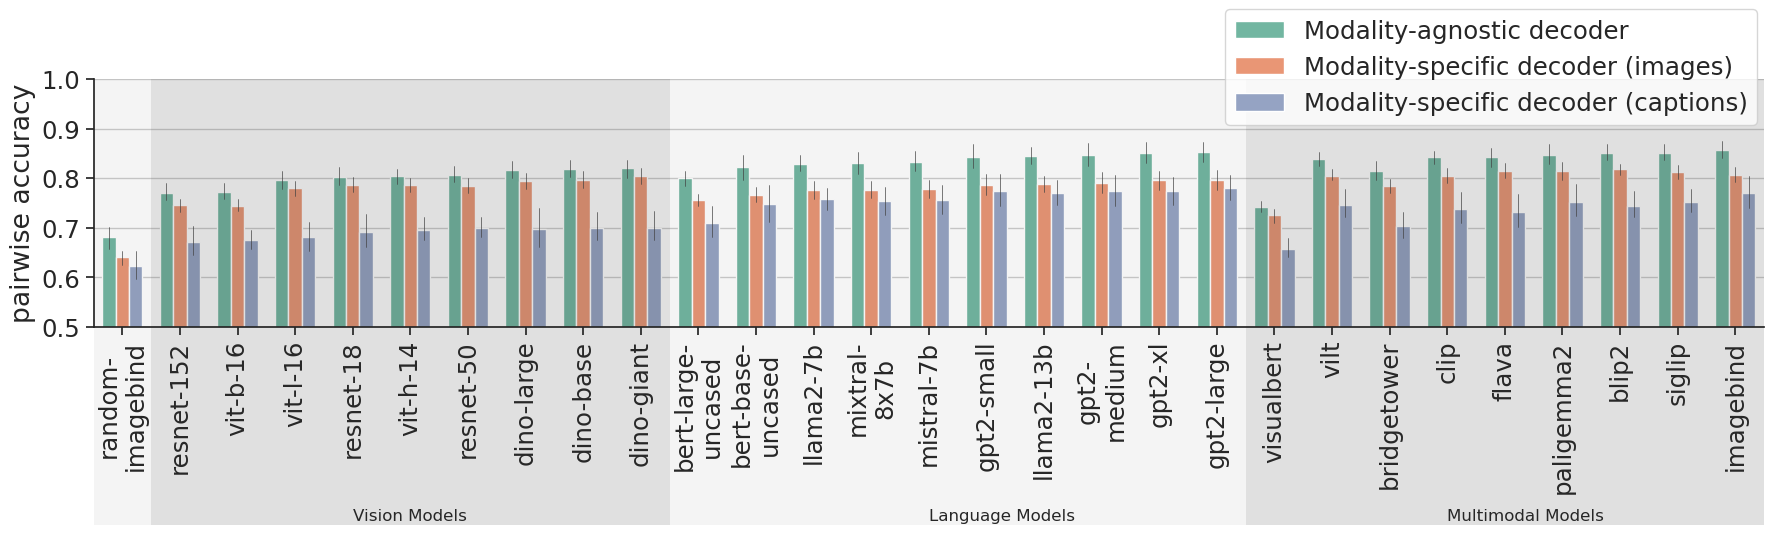

In [21]:
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

# model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = [ACC_MEAN]
HUE_ORDER = [MODALITY_AGNOSTIC, MODALITY_SPECIFIC_IMAGES, MODALITY_SPECIFIC_CAPTIONS]

figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=HUE_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.68, 1.05), height=5, aspect=3.2, legend_title="", verify_num_datapoints=False)

figure.axes[0][0].add_patch(
 patches.Rectangle(
 (-0.5, 0.1), # (x,y)
 1, # width
0.9, # height
     linewidth=0,
     clip_on=False,
     alpha=0.05,
     color='0.2'
 )
)
figure.axes[0][0].add_patch(
 patches.Rectangle(
 (0.5, 0.1), # (x,y)
 9, # width
0.9, # height
     linewidth=0,
     clip_on=False,
     alpha=0.15,
     color='0.2'
 )
)
figure.axes[0][0].add_patch(
 patches.Rectangle(
 (9.5, 0.1), # (x,y)
 10, # width
 0.9, # height
     linewidth=0,
     clip_on=False,
     alpha=0.05,
     color='0.2'
 )
)
figure.axes[0][0].add_patch(
 patches.Rectangle(
 (19.5, 0.1), # (x,y)
 9, # width
 0.9, # height
     linewidth=0,
     clip_on=False,
     alpha=0.15,
     color='0.2'
 )
)
figure.axes[0][0].text(4, 0.11, 'Vision Models', fontsize=12)
figure.axes[0][0].text(14, 0.11, 'Language Models', fontsize=12)
figure.axes[0][0].text(23, 0.11, 'Multimodal Models', fontsize=12)

plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0.3, dpi=300)


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels(


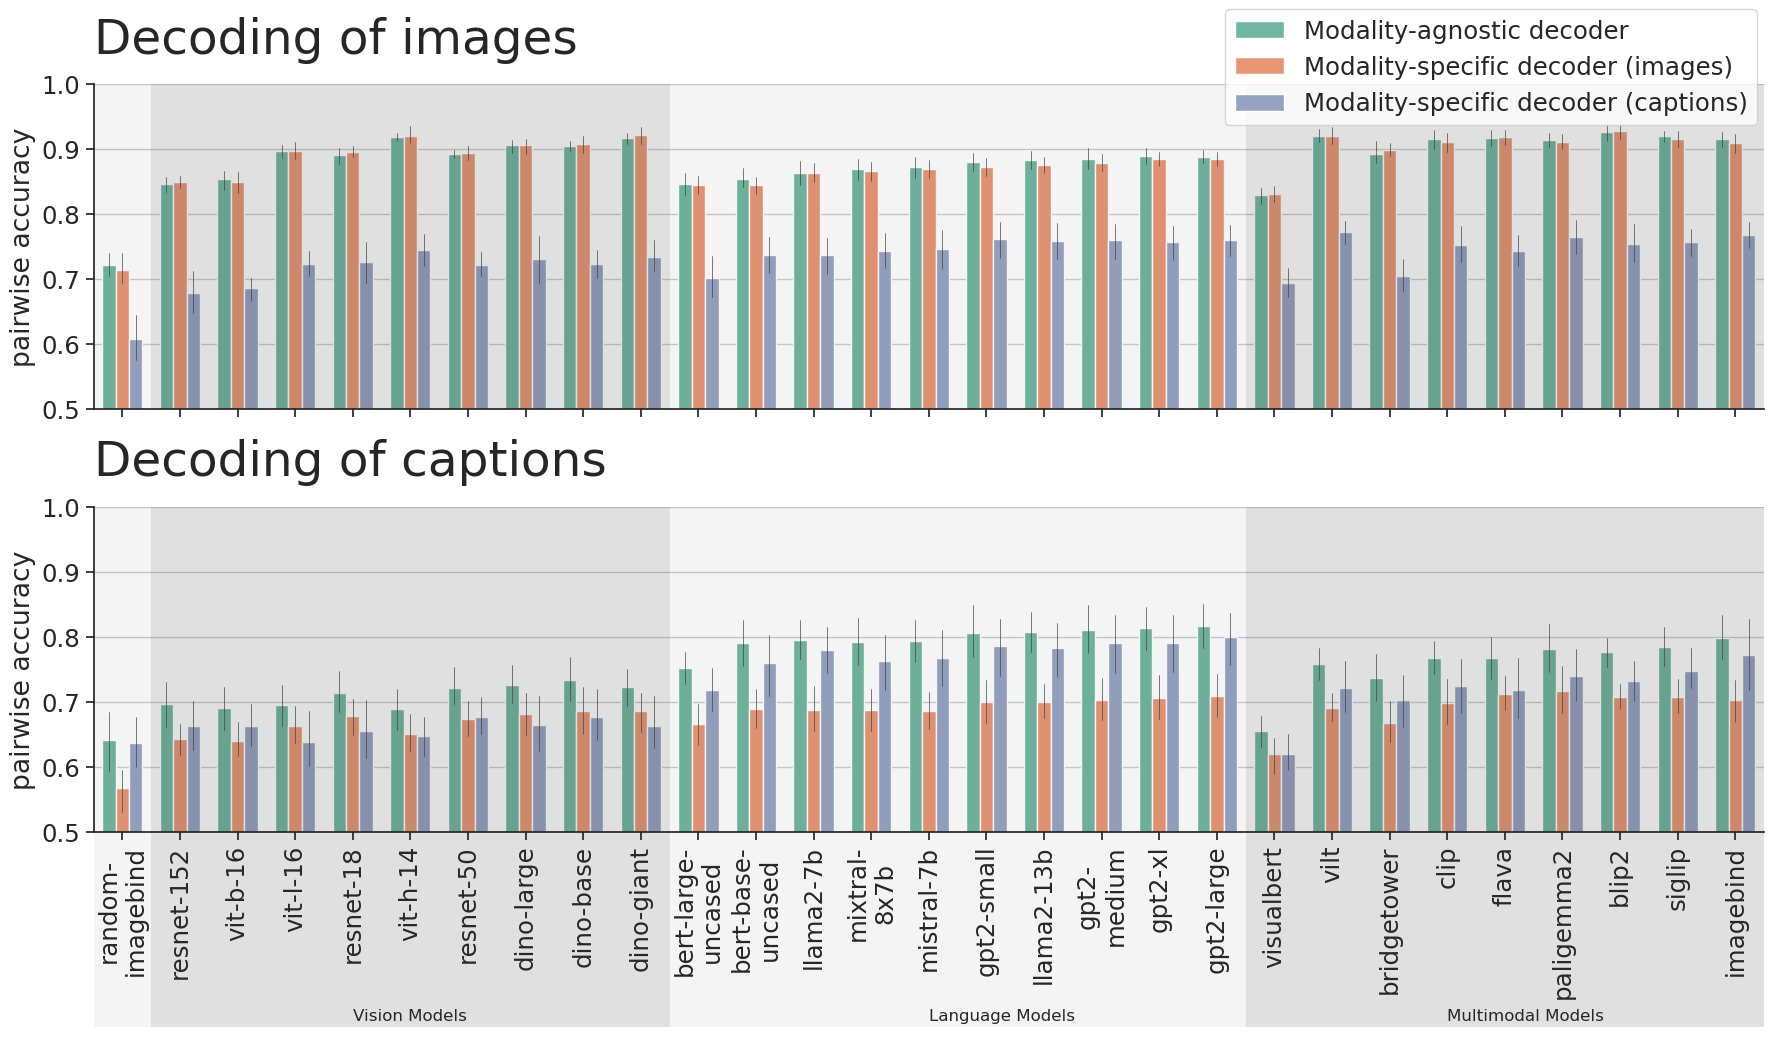

In [24]:
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

# model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = [ACC_IMAGES, ACC_CAPTIONS]
HUE_ORDER = [MODALITY_AGNOSTIC, MODALITY_SPECIFIC_IMAGES, MODALITY_SPECIFIC_CAPTIONS]

figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=HUE_ORDER, ylim=(0.5, 1), row_title_height=1.07, row_title_loc='left',
 legend_bbox=(0.68, 1.03), height=5, aspect=3.2, legend_title="", verify_num_datapoints=False)

height=0.5
figure.axes[0][0].add_patch(
 patches.Rectangle(
 (-0.5, 0.5), # (x,y)
 1, # width
 height, # height
     linewidth=0,
     clip_on=False,
     alpha=0.05,
     color='0.2'
 )
)
figure.axes[0][0].add_patch(
 patches.Rectangle(
 (0.5, 0.5), # (x,y)
9, # width
height, # height
     linewidth=0,
     clip_on=False,
     alpha=0.15,
     color='0.2'
 )
)
figure.axes[0][0].add_patch(
 patches.Rectangle(
 (9.5, 0.5), # (x,y)
 10, # width
height, # height
     linewidth=0,
     clip_on=False,
     alpha=0.05,
     color='0.2'
 )
)
figure.axes[0][0].add_patch(
 patches.Rectangle(
 (19.5, 0.5), # (x,y)
 9, # width
height, # height
     linewidth=0,
     clip_on=False,
     alpha=0.15,
     color='0.2'
 )
)

height=0.8
figure.axes[1][0].add_patch(
 patches.Rectangle(
 (-0.5, 0.2), # (x,y)
 1, # width
 height, # height
     linewidth=0,
     clip_on=False,
     alpha=0.05,
     color='0.2'
 )
)
figure.axes[1][0].add_patch(
 patches.Rectangle(
 (0.5, 0.2), # (x,y)
9, # width
height, # height
     linewidth=0,
     clip_on=False,
     alpha=0.15,
     color='0.2'
 )
)
figure.axes[1][0].add_patch(
 patches.Rectangle(
 (9.5, 0.2), # (x,y)
 10, # width
height, # height
     linewidth=0,
     clip_on=False,
     alpha=0.05,
     color='0.2'
 )
)
figure.axes[1][0].add_patch(
 patches.Rectangle(
 (19.5, 0.2), # (x,y)
 9, # width
height, # height
     linewidth=0,
     clip_on=False,
     alpha=0.15,
     color='0.2'
 )
)
figure.axes[1][0].text(4, 0.21, 'Vision Models', fontsize=12)
figure.axes[1][0].text(14, 0.21, 'Language Models', fontsize=12)
figure.axes[1][0].text(23, 0.21, 'Multimodal Models', fontsize=12)

plt.subplots_adjust(hspace=0.3)

plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_split_by_modality.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0.5, dpi=300)

# Statistical tests

In [14]:
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf


## Mod agnostic vs. mod specific

In [16]:
data_default_feats_copy = data_default_feats.copy()

for metric, comparison_training_mode in zip(['pairwise_acc_mean', 'pairwise_acc_mean'], ["images", "captions"]):
    print(f"{metric} | comparison with {comparison_training_mode}")
    data_filtered = data_default_feats_copy[data_default_feats_copy.metric == metric]
    data_mod_agno = data_filtered[data_filtered.training_mode == "agnostic"]
    assert len(data_mod_agno) == len(SUBJECTS) * len(data_mod_agno.model.unique())

    data_mod_spec = data_filtered[data_filtered.training_mode == comparison_training_mode]
    assert len(data_mod_spec) == len(SUBJECTS) * len(data_mod_spec.model.unique())

    print('mod agno: ', data_mod_agno.value.mean())
    print('mod spec: ', data_mod_spec.value.mean())

    # display(ttest_ind(data_mod_agno.value.values, data_mod_spec.value.values))

    # display(data_mod_agno)
    data_anova = pd.concat([data_mod_agno, data_mod_spec])
    data_anova = data_anova[['model', 'subject', 'training_mode', 'value']]

    mod = smf.mixedlm("value ~ training_mode", data_anova, groups=data_anova["subject"]).fit()

    print("=" * 50 + "\nANOVA\n" + "=" * 50)
    print(mod.summary())
    print('pvalues:\n', mod.pvalues)
    print('\n')
    

pairwise_acc_mean | comparison with images
mod agno:  0.8185627424383046
mod spec:  0.7814634349491921
ANOVA
              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     value   
No. Observations:     348         Method:                 REML    
No. Groups:           6           Scale:                  0.0015  
Min. group size:      58          Log-Likelihood:         626.2356
Max. group size:      58          Converged:              Yes     
Mean group size:      58.0                                        
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.819    0.009 92.693 0.000  0.801  0.836
training_mode[T.images] -0.037    0.004 -9.055 0.000 -0.045 -0.029
Group Var                0.000    0.007                           

pvalues:
 Intercept               

/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## Mod agnostic vs. mod specific - imagery decoding

In [17]:
# from scipy.stats import ttest_ind
# from pymer4.models import Lmer

# data_ttest = data_default_feats.copy()

# for metric in [ACC_IMAGERY_WHOLE_TEST, ACC_IMAGERY]:
#     for comparison_training_mode in ["images", "captions"]:
#         print(f"{metric} | comparison with {comparison_training_mode}")
#         data_filtered = data_ttest[data_ttest.metric == metric]
#         data_mod_agno = data_filtered[data_filtered.training_mode == "agnostic"]
#         # data_mod_agno = data_mod_agno[data_mod_agno.model == "imagebind"]
#         assert len(data_mod_agno) == len(SUBJECTS) * len(data_mod_agno.model.unique())
    
#         data_mod_spec = data_filtered[data_filtered.training_mode == comparison_training_mode]
#         assert len(data_mod_spec) == len(SUBJECTS) * len(data_mod_spec.model.unique())
    
#         print('mod agno: ', data_mod_agno.value.mean())
#         print('mod spec: ', data_mod_spec.value.mean())
#         print(len(data_mod_agno.value.values))
#         print(ttest_ind(data_mod_agno.value.values, data_mod_spec.value.values))
    
#         # display(data_mod_agno)
#         data_glm = pd.concat([data_mod_agno, data_mod_spec])
#         # display(data_glm)
#         mod = Lmer('value ~ training_mode + (1 | subject)', data=data_glm)
#         # mod = Lmer('value ~ training_mode + (1 | model) + (1 | subject)', data=data_glm)

#         print("=" * 50 + "\nGLM\n" + "=" * 50)
#         fitted = mod.fit()
#         print(fitted)
#         print(fitted[["Estimate", "SE", "Sig"]])
#         print('\n')

In [18]:
data_ttest = data_default_feats.copy()

for metric in [ACC_IMAGERY_WHOLE_TEST]:
    for comparison_training_mode in ["images", "captions"]:
        print(f"{metric} | comparison with {comparison_training_mode}")
        data_filtered = data_ttest[data_ttest.metric == metric]

        data_mod_agno = data_filtered[data_filtered.training_mode == "agnostic"]
        assert len(data_mod_agno) == len(SUBJECTS) * len(data_mod_agno.model.unique())
    
        data_mod_spec = data_filtered[data_filtered.training_mode == comparison_training_mode]
        assert len(data_mod_spec) == len(SUBJECTS) * len(data_mod_spec.model.unique())
    
        print('mod agno: ', data_mod_agno.value.mean())
        print('mod spec: ', data_mod_spec.value.mean())
        print(ttest_ind(data_mod_agno.value.values, data_mod_spec.value.values))
    
        # display(data_mod_agno)
        data_anova = pd.concat([data_mod_agno, data_mod_spec])
        data_anova = data_anova[['model', 'subject', 'training_mode', 'value']]

        # print(data_anova)

        mod = smf.mixedlm("value ~ training_mode", data_anova, groups=data_anova["subject"]).fit()

        print("=" * 50 + "\nANOVA\n" + "=" * 50)
        print(mod.summary())
        print('pvalues:\n', mod.pvalues)

        print('\n')
        

pairwise_acc_imagery_whole_test_set | comparison with images
mod agno:  0.7246505855053694
mod spec:  0.6942420808375156
TtestResult(statistic=2.2385468337567818, pvalue=0.025820857990086925, df=346.0)
ANOVA
              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     value   
No. Observations:     348         Method:                 REML    
No. Groups:           6           Scale:                  0.0099  
Min. group size:      58          Log-Likelihood:         292.7339
Max. group size:      58          Converged:              Yes     
Mean group size:      58.0                                        
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.725    0.036 20.262 0.000  0.655  0.795
training_mode[T.images] -0.030    0.011 -2.850 0.004 -0.051 -0.009
Gro

/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## Effect of multimodal model architecture

In [19]:
data_ttest = data_default_feats.copy()

for metric in [ACC_MEAN]:
    print(f"{metric}")
    data_filtered = data_ttest[data_ttest.metric == metric]
    data_mod_agno = data_filtered[data_filtered.training_mode == "agnostic"]
    data_mod_agno = data_mod_agno[data_mod_agno.model != "random-imagebind"]

    assert len(data_mod_agno) == len(SUBJECTS) * len(data_mod_agno.model.unique())

    data_dual_stream = data_mod_agno[data_mod_agno.model.isin(['clip', 'imagebind', 'siglip'])].copy()
    data_dual_stream['multimodal_type'] = 'dual_stream'
    data_single_stream_early_fusion = data_mod_agno[data_mod_agno.model.isin(['visualbert', 'vilt', 'paligemma2'])].copy()
    data_single_stream_early_fusion['multimodal_type'] = 'single_stream_early_fusion'
    data_single_stream_late_fusion = data_mod_agno[data_mod_agno.model.isin(['bridgetower', 'flava', 'blip2'])].copy()
    data_single_stream_late_fusion['multimodal_type'] = 'single_stream_late_fusion'


    print('data_dual_stream: ', data_dual_stream.value.mean())
    print(len(data_dual_stream.value.values))
    print('data_single_stream_early_fusion: ', data_single_stream_early_fusion.value.mean())
    print(len(data_single_stream_early_fusion.value.values))
    print('data_single_stream_late_fusion: ', data_single_stream_late_fusion.value.mean())
    print(len(data_single_stream_late_fusion.value.values))

    # print(ttest_ind(data_mod_agno.value.values, data_mod_spec.value.values))

    data_anova = pd.concat([data_dual_stream, data_single_stream_early_fusion, data_single_stream_late_fusion])
    data_anova = data_anova[['subject', 'multimodal_type', 'value']]

    mod = smf.mixedlm("value ~ multimodal_type", data_anova, groups=data_anova["subject"]).fit()

    print("=" * 50 + "\nANOVA\n" + "=" * 50)
    # print(mod.random_effects)
    print(mod.summary())
    print('pvalues:\n', mod.pvalues)

    print('\n')
    

pairwise_acc_mean
data_dual_stream:  0.8503968253968254
18
data_single_stream_early_fusion:  0.8101161720726938
18
data_single_stream_late_fusion:  0.8362778927996319
18
ANOVA
                         Mixed Linear Model Regression Results
Model:                         MixedLM            Dependent Variable:            value  
No. Observations:              54                 Method:                        REML   
No. Groups:                    6                  Scale:                         0.0011 
Min. group size:               9                  Log-Likelihood:                94.2866
Max. group size:               9                  Converged:                     Yes    
Mean group size:               9.0                                                      
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------

/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## Comparing cross-decoding for images and captions

In [34]:
data_filtered = data_default_feats.copy()

# for metric, comparison_training_mode in zip(['pairwise_acc_mean', 'pairwise_acc_mean'], ["images", "captions"]):
# print(f"{metric} | comparison with {comparison_training_mode}")
# data_filtered = data_default_feats_copy[data_default_feats_copy.metric == 'pairwise_acc_mean']
data_cross_images = data_filtered[(data_filtered.training_mode == "captions") & (data_filtered.metric == 'pairwise_acc_images')]
assert len(data_cross_images) == len(SUBJECTS) * len(data_cross_images.model.unique())

data_cross_captions = data_filtered[(data_filtered.training_mode == "images") & (data_filtered.metric == 'pairwise_acc_captions')]
assert len(data_cross_captions) == len(SUBJECTS) * len(data_cross_captions.model.unique())

print('data_cross_images: ', data_cross_images.value.mean())
print('data_cross_captions: ', data_cross_captions.value.mean())

# display(ttest_ind(data_mod_agno.value.values, data_mod_spec.value.values))

# # display(data_mod_agno)
data_anova = pd.concat([data_cross_images, data_cross_captions])
data_anova = data_anova[['model', 'subject', 'training_mode', 'value']]

mod = smf.mixedlm("value ~ training_mode", data_anova, groups=data_anova["subject"]).fit()

print("=" * 50 + "\nANOVA\n" + "=" * 50)
print(mod.summary())
print('pvalues:\n', mod.pvalues)
print('\n')


data_cross_images:  0.7331143951833606
data_cross_captions:  0.6803110349587113
ANOVA
               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     value   
No. Observations:      348         Method:                 REML    
No. Groups:            6           Scale:                  0.0017  
Min. group size:       58          Log-Likelihood:         597.0271
Max. group size:       58          Converged:              Yes     
Mean group size:       58.0                                        
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                0.733    0.012  61.085 0.000  0.710  0.757
training_mode[T.images] -0.053    0.004 -11.885 0.000 -0.062 -0.044
Group Var                0.001    0.013                            

pvalues:
 Intercept                  0.00000

/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# Imagery decoding feat comparison

/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels(


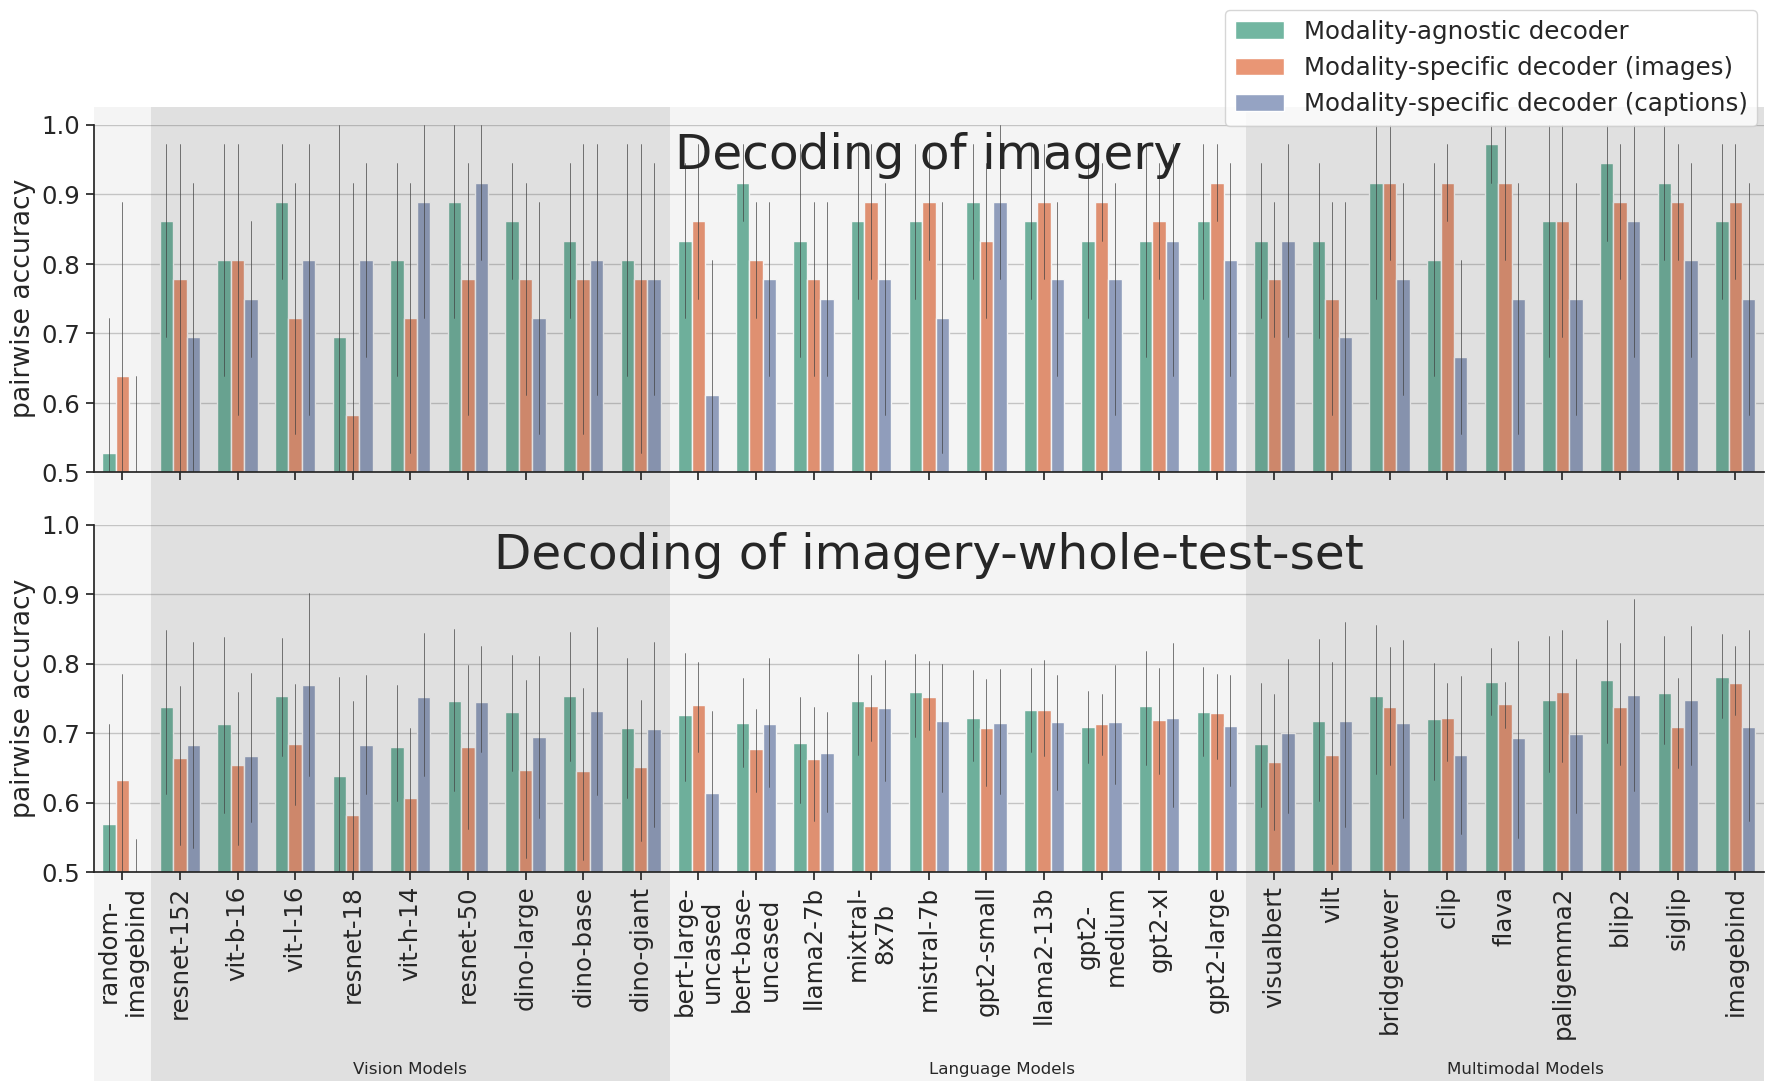

In [22]:
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

# model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = [ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST]
HUE_ORDER = [MODALITY_AGNOSTIC, MODALITY_SPECIFIC_IMAGES, MODALITY_SPECIFIC_CAPTIONS]

figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=HUE_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.68, 1.07), height=5, aspect=3.2, legend_title="", verify_num_datapoints=False)

figure.axes[1][0].add_patch(
 patches.Rectangle(
 (-0.5, 0.2), # (x,y)
 1, # width
 1.4, # height
     linewidth=0,
     clip_on=False,
     alpha=0.05,
     color='0.2'
 )
)
figure.axes[1][0].add_patch(
 patches.Rectangle(
 (0.5, 0.2), # (x,y)
9, # width
 1.4, # height
     linewidth=0,
     clip_on=False,
     alpha=0.15,
     color='0.2'
 )
)
figure.axes[1][0].add_patch(
 patches.Rectangle(
 (9.5, 0.2), # (x,y)
 10, # width
 1.4, # height
     linewidth=0,
     clip_on=False,
     alpha=0.05,
     color='0.2'
 )
)
figure.axes[1][0].add_patch(
 patches.Rectangle(
 (19.5, 0.2), # (x,y)
 9, # width
 1.4, # height
     linewidth=0,
     clip_on=False,
     alpha=0.15,
     color='0.2'
 )
)
figure.axes[1][0].text(4, 0.21, 'Vision Models', fontsize=12)
figure.axes[1][0].text(14, 0.21, 'Language Models', fontsize=12)
figure.axes[1][0].text(23, 0.21, 'Multimodal Models', fontsize=12)

plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_imagery.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0.3, dpi=300)


## Per-subject results

/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels(
/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels(


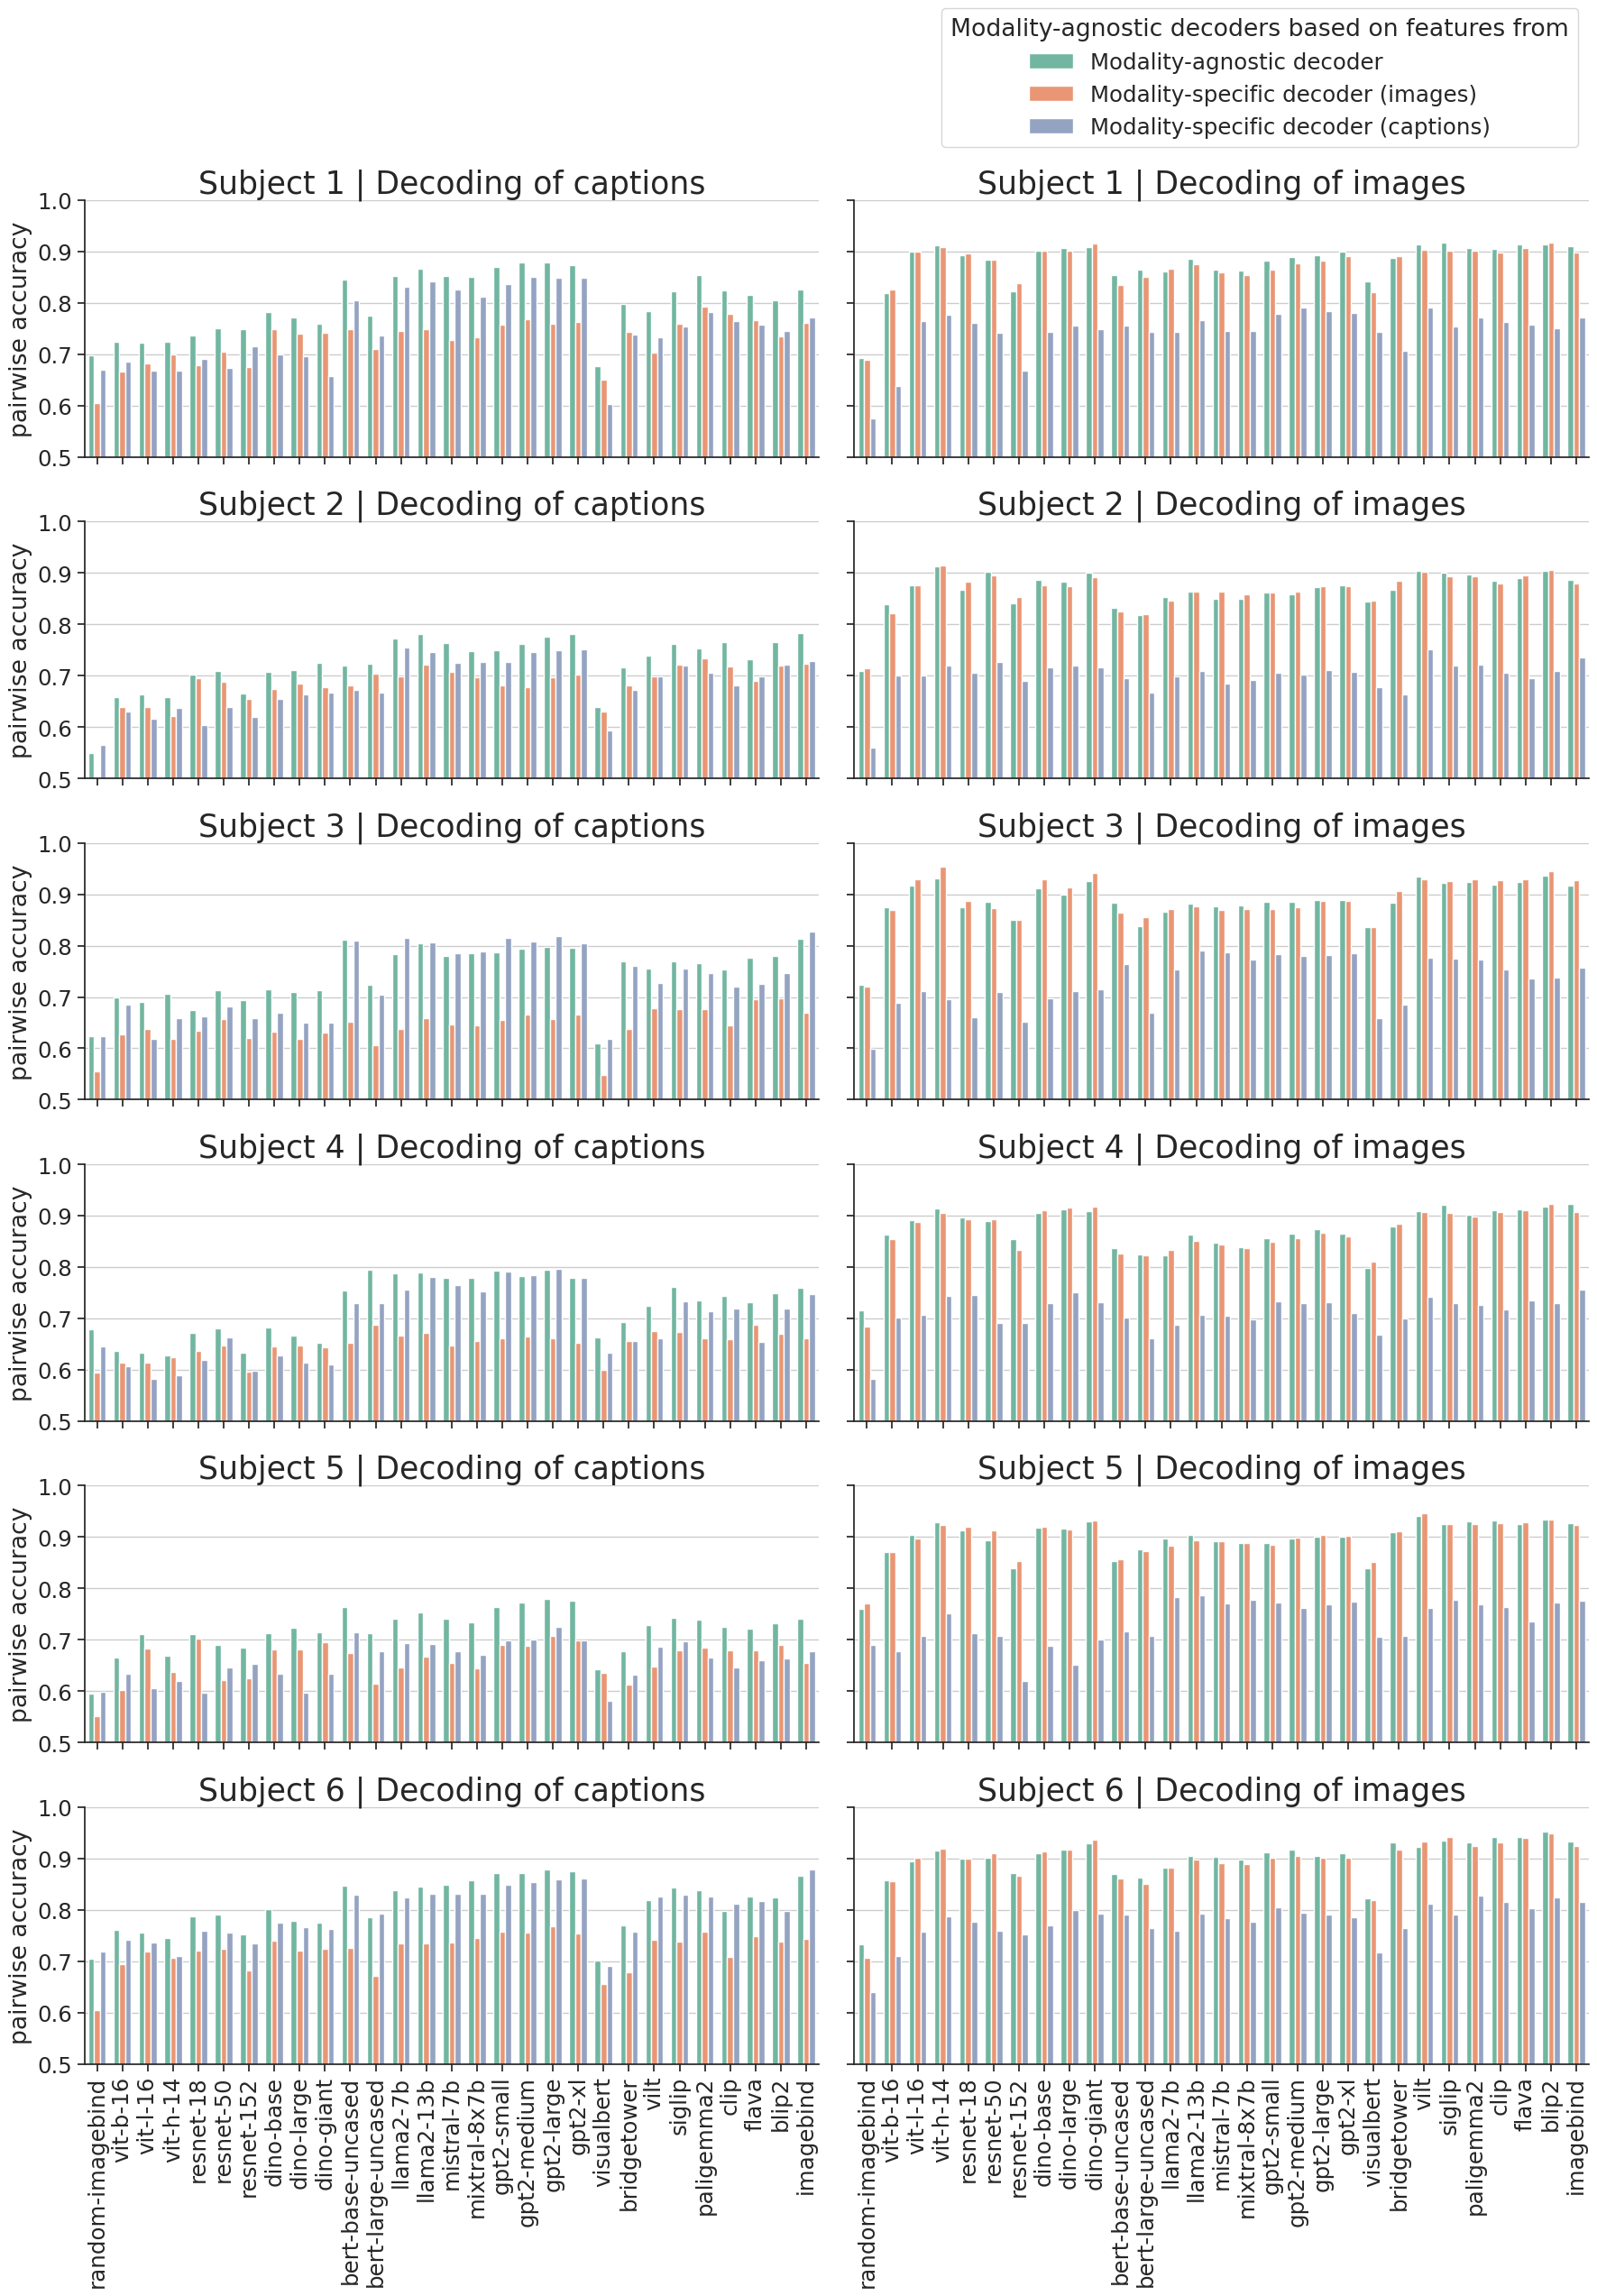

In [27]:
FEAT_ORDER = ["vision", "lang", "matched"]
FEAT_PALETTE = sns.color_palette('Set2')[:3]

def create_result_graph_all_subjs(data, order=model_feat_order, metrics=[ACC_CAPTIONS, ACC_IMAGES], hue_variable="training_mode", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Modality-agnostic decoders based on features from", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None, plot_modality_specific=True,
                       row_variable="metric", col_variable=None, legend_bbox=None):
    for mode in TRAINING_MODES:
        data_mode = data[data.training_mode == mode]
        for x_variable_value in order:
            length = len(data_mode[(data_mode["model_feat"] == x_variable_value) & (data_mode.metric == metrics[0])])
            expected_num_datapoints = len(SUBJECTS)
            # if hue_variable != "features":
            #     expected_num_datapoints *= len(data[hue_variable].unique())
            if (length > 0) and (length != expected_num_datapoints):
                message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) (model_feat: {x_variable_value} {mode}"
                print(f"Warning: {message}")

    catplot_g, data_plotted, lgd = plot_metric_catplot(data, order=model_feat_order, metrics=metrics, x_variable="model_feat", legend_title=legend_title, aspect=2, legend_bbox=legend_bbox, rotation=90, cut_labels=False,
                                                  hue_variable=hue_variable, row_variable=row_variable, col_variable=col_variable, hue_order=hue_order, palette=palette, ylim=ylim, noise_ceilings=noise_ceilings)

    for i in range(len(data.subject.unique())):
        catplot_g.axes[i,0].set_title(f"Subject {i+1} | Decoding of captions", fontsize=25)
        catplot_g.axes[i,1].set_title(f"Subject {i+1} | Decoding of images", fontsize=25)
    
        catplot_g.axes[i,0].set_ylabel('pairwise accuracy')

    return catplot_g, lgd

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = calc_model_feat_order(data_to_plot, MODELS)
HUE_ORDER = [MODALITY_AGNOSTIC, MODALITY_SPECIFIC_IMAGES, MODALITY_SPECIFIC_CAPTIONS]


figure, lgd = create_result_graph_all_subjs(data_to_plot, model_feat_order, metrics=[ACC_CAPTIONS, ACC_IMAGES], hue_order=HUE_ORDER, ylim=(0.5, 1), row_variable="subject", col_variable="metric", legend_bbox=(0.58, 1.07))
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_per_subject.png"), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0)

# 

# Error analysis

In [ ]:
models = ['imagebind']

data = load_results_data(models, metrics=METRICS_ERROR_ANALYSIS)

# metric = ACC_IMAGES

all_data = data[data.model.isin(MODELS)]

all_data = all_data[all_data["mask"] == "whole_brain"]

all_data = all_data[all_data.surface == True]

data_default_feats_err_analysis = get_data_default_feats(all_data)

In [ ]:
def all_pairwise_accuracy_scores(latents, predictions, stim_types=None, metric="cosine", standardize=True):
    results = dict()
    results['comp_mats'] = dict()
    
    for modality, acc_metric_name in zip([CAPTION, IMAGE], [ACC_CAPTIONS, ACC_IMAGES]):
        preds_mod = predictions[stim_types == modality].copy()
        latents_mod = latents[stim_types == modality]
        if standardize:
            preds_mod = StandardScaler().fit_transform(preds_mod)

        dist_mat = get_distance_matrix(preds_mod, latents_mod, metric)
        diag = dist_mat.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat

        score = dist_mat_to_pairwise_acc(dist_mat)

        results[acc_metric_name] = score
        results['comp_mats'][acc_metric_name] = (~comp_mat).astype(int)

    if standardize:
        predictions = StandardScaler().fit_transform(predictions)

    dist_mat = get_distance_matrix(predictions, latents, metric)

    mod_agnostic_accs = []
    for modality in [CAPTION, IMAGE]:
        dist_mat_within_mod = dist_mat[stim_types == modality][:, stim_types == modality]
        dist_mat_cross_modal = dist_mat[stim_types == modality][:, stim_types != modality]
        dist_mat_min = np.min((dist_mat_within_mod, dist_mat_cross_modal), axis=0)
        diag = dist_mat_min.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat_min
        score = dist_mat_to_pairwise_acc(dist_mat_min)
        # scores = np.mean(comp_mat, axis=0)
        mod_agnostic_accs.append(score)
        results[f"pairwise_acc_mod_agnostic_{modality}s"] = score
        results['comp_mats'][f"pairwise_acc_mod_agnostic_{modality}s"] = (~comp_mat).astype(int)

    results[ACC_MODALITY_AGNOSTIC] = np.mean(mod_agnostic_accs)

    return results

metric = ACC_IMAGES #TODO which metric?
training_type = MODALITY_AGNOSTIC

all_subj_mats = []
for subject in SUBJECTS:
    df = data_default_feats_err_analysis.copy()
    df_subj = df[(df.training_mode == training_type) & (df.subject == subject)]
    predictions = df_subj[df_subj.metric == "predictions"].value.item()
    latents = df_subj[df_subj.metric == "latents"].value.item()
    stimulus_ids = df_subj[df_subj.metric == "stimulus_ids"].value.item()
    stimulus_types = df_subj[df_subj.metric == "stimulus_types"].value.item()
    
    results = all_pairwise_accuracy_scores(latents, predictions, stimulus_types)
    print(results[ACC_IMAGES])    
    mat = results['comp_mats'][metric]
    all_subj_mats.append(mat)

mat = np.sum(all_subj_mats, axis=0)
mat = mat - np.diag(np.diag(mat))

df_err = pd.DataFrame(mat, index=stimulus_ids[:70], columns=stimulus_ids[:70])

In [ ]:
# df_err = df_err.map(lambda x: 0 if x < 3 else x)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(df_err)

In [ ]:
stimuli_info = pd.read_csv(STIM_INFO_PATH, index_col=0)
stimuli_info = stimuli_info[stimuli_info.used == True]
captions_dict = stimuli_info.caption.to_dict()

img_paths = stimuli_info.img_path.to_dict()

img_paths = {idx: os.path.join(COCO_IMAGES_DIR, path) for idx, path in img_paths.items()}

from PIL import Image

def display_stimuli(coco_ids):
    imgs = [Image.open(img_paths[img_id]).convert('RGB') for img_id in coco_ids]
    min_height = np.min([np.array(im).shape[0] for im in imgs])
    stacked = np.hstack([np.array(im)[:min_height,:,:] for im in imgs])
    img = Image.fromarray(stacked)
    # print(min_height)
    captions = [captions_dict[coco_id] for coco_id in coco_ids]
    for cap in captions:
        print(cap)
    display(img)
    
# display_stimuli([16764, 79642])


In [ ]:
for id1, row in df_err.iterrows():
    confusions = []
    for id2, count in row.items():
        if count > 5:
            confusions.append(id2)
    if len(confusions) > 0:
        print(f'common confusions involving id {id1}:\n')
        confusions = [id1] + confusions
        display_stimuli(confusions)
        print('\n\n')
